# Sprint12課題 深層学習スクラッチ畳み込みニューラルネットワーク1

## この課題の目的

- スクラッチを通してCNNの基礎を理解する

## スクラッチによる実装

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

Sprint11で作成したディープニューラルネットワークのクラスを拡張する形でCNNを作成します。まず、Sprint12で1次元畳み込み層を作成し、畳み込みの基礎を理解することを目指します。そして、Sprint13で一般的に画像に対して使われる2次元畳み込み層とプーリング層を作成します。

### 1次元畳み込み層

畳み込みニューラルネットワークは画像に対して使われる2次元畳み込みが代表的ですが、理解を容易にするためにまずは1次元畳み込みを実装します。1次元畳み込みは系列データで使われることが多いです。畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまでがフレームワークで一般的に用意されています。

### データセットの用意

引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [1]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 1, 784)
X_test = X_test.reshape(-1, 1, 784)

In [4]:
X_train = X_train[:480]
y_train = y_train[:480]
X_test = X_test[:120]
y_test = y_test[:120]

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_val.shape)

(384, 1, 784)
(96, 1, 784)


### CNN分類器クラスの作成

1次元畳み込みニューラルネットワークモデルのクラスScratch1dCNNClassifierを作成してください。Sprint11で作成したScratchDeepNeuralNetrowkClassifierを元にしてください。

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造はsprint11で作成したFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。

ここではパディングは考えず、ストライドも1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

フォワードプロパゲーションの数式は以下のようになります。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$  : 出力される配列のi番目の値

$F$ : フィルタのサイズ

$x_{(i+s)}$ : 入力の配列の(i+s)番目の値

$w_s$ : 重みの配列のs番目の値

$b$ : バイアス項

全てスカラーです。

次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$$
w_s^{\prime} = w_s - \alpha \frac{\partial L}{\partial w_s}
$$

$$
b^{\prime} = b - \alpha \frac{\partial L}{\partial b}
$$

$\alpha$  : 学習率

$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配

勾配$\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}
$$

$$
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値

$N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値

ただし、$j-s<0$または$j-s>N_{out}-1$のとき$\frac{\partial L}{\partial a_{(j-s)}} =0$です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [7]:
class SimpleConv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層クラス
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, filter_size, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes2, n_nodes1, filter_size)
        self.B = initializer.B(n_nodes2)
        
        #
        self.X = None
        self.index = None
        self.n_out = None

    
    def forward(self, X):
        """
        フォワードプロバケーション
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        a : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #Xをコピー
        self.X = X.copy()
        
        #配列作成
        idx1 = np.arange(self.W.shape[0])
        idx2 = np.arange(self.W.shape[0] - 1).reshape(-1, 1)
        self.index = idx1 + idx2

        #出力の計算
        a = np.dot(X[idx1 + idx2], self.W.T) + self.B

        return a
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dX : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        #バイアス
        dB = np.sum(dA)
        
        #重み
        dW = np.dot(da, self.X[self.index])
        
        #0配列を用意
        dX = np.zeros(self.X.shape[0])
        
        #n_out
        self.n_out = self._n_out(self.X.shape[0], 0, self.W.shape[0], 1)
                
        #計算
        for j in range(self.X.shape[0]):
            for s in range(self.W.shape[0]):

                #場合分け
                if j - s < 0 or j - s > self.n_out - 1:
                     dX[j] += 0 * self.W[s]
                else:
                    dX[j] += dA[j - s] * self.W[s]

        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        return dX
    
    
    def _n_out(self, n_in, P, F, S):
        '''
        出力サイズの計算
        
        Parameters
        --------------
        n_in : int
            入力のサイズ
        P : int
            パディング数
        F : 
            フィルター(重み)のサイズ
        S : 
            ストライドのサイズ
            
        returns
        ---------
        n_out : int
            出力のサイズ
        '''
        n_out = int(((n_in + 2 * P - F) / S ) + 1)
        
        return n_out

## 【問題2】1次元畳み込み後の出力サイズの計算

畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。

$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

In [8]:
def n_out(n_in, P, F, S):
    n_out = int(((n_in + 2 * P - F) / S ) + 1)
    return n_out

## 【問題3】小さな配列での1次元畳み込み層の実験

次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みw、バイアスbを次のようにします。

```python
x = np.array([1,2,3,4])  
w = np.array([3, 5, 7])  
b = np.array([1]) 
```


フォワードプロパゲーションをすると出力は次のようになります。

```python
a = np.array([35, 50])
```

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

```python
delta_a = np.array([10, 20])
```

バックプロパゲーションをすると次のような値になります。

```python
delta_b = np.array([30])  
delta_w = np.array([50, 80, 110])  
delta_x = np.array([30, 110, 170, 140])
```

### 実装上の工夫

畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。

$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

バイアス項は単純な足し算のため、重みの部分を見ます。

$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$

これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

```python
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])

a = np.empty((2, 3))

indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)

a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)
```

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

```python
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)

print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])
```

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

<u>参考</u>

以下のページのInteger array indexingの部分がこの方法についての記述です。

[Indexing — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

#### ・フォワードプロバケーション

In [9]:
#フォワードプロバケーションの初期値
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [10]:
#配列作成
idx1 = np.arange(w.shape[0])
idx2 = np.arange(w.shape[0] - 1).reshape(-1, 1)
index = idx1 + idx2

#出力の計算
a = np.dot(x[index], w.T) + b
        
a

array([35, 50])

In [11]:
#バックプロバケーションの初期値
da = np.array([10, 20])

In [12]:
db = np.sum(da)
db

30

In [13]:
dw = np.dot(da, x[index])
dw

array([ 50,  80, 110])

In [14]:
#0配列を用意
dx = np.zeros(x.shape[0])

#計算
for j in range(x.shape[0]):
    for s in range(w.shape[0]):
        
        #場合分け
        if j - s < 0 or j - s > 1:
             dx[j] += 0 * w[s]
        else:
            dx[j] += da[j - s] * w[s]

dx

array([ 30., 110., 170., 140.])

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

紙やホワイトボードを使い計算グラフを書きながら考えてください。

例えば以下のようなx, w, bがあった場合は、

```python
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。  
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。  
b = np.array([1, 2, 3]) # （出力チャンネル数）
```

出力は次のようになります。

```python
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。
```

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

補足

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [16]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]])  # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

#バッチ数を追加
x = x[np.newaxis, :]

#shapeの取得
batch, C, W = x.shape #(バッチサイズ, 入力チャンネル, 特徴量)
FN, C, FS = w.shape #(出力チャンネル,  入力チャンネル, フィルタサイズ)

#出力のサイズ(特徴量方向)
out_w = n_out(W, 0, FS, 1)

#出力の形
a = np.zeros((batch, FN, out_w)) #(バッチサイズ, 出力チャンネル数, 特徴量数)

#バッチ数
for i in range(batch):
    #出力チャンネル数
    for j in range(FN):
        #入力チャンネル数
        for k in range(C):
            #特徴量数
            for l in range(out_w):
                #足しあげる
                a[i, j, l] += np.sum(x[i, k, l: l+FS] * w[j, k, :] ) 

#バイアスを足す
a += b.reshape(1, -1, 1)

print(a)

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]


In [17]:
#バックプロバケーションの初期値
da = np.array([[10, 20], [10, 20], [10, 20]])

FN, C, FS = w.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
batch, C, W = x.shape # (バッチサイズ、入力チャンネル数、特徴量数)

#da(バッチサイズ, 出力チャンネル数, 特徴量数)
da = da[np.newaxis, :]

#ｗの勾配
dw = np.zeros(w.shape)

#xの勾配
dx = np.zeros(x.shape)

#バッチサイズ
for i in range(batch):
    #出力チャンネル
    for j in range(FN):
        #入力チャンネル
        for k in range(C):
            #フィルタサイズ
            for l in range(FS):
                #出力特徴量
                for m in range(out_w):
                    #足しあげる
                    dw[j, k, l] += da[i, j, m] * x[i, k, l + m]
                    dx[i, k, l + m] += da[i, j, m] * w[j, k, l]

#bの勾配
db = da.sum(axis=2)
        
print('dw :\n', dw)
print('dx :\n', dx)
print('db :\n', db)

dw :
 [[[ 50.  80. 110.]
  [ 80. 110. 140.]]

 [[ 50.  80. 110.]
  [ 80. 110. 140.]]

 [[ 50.  80. 110.]
  [ 80. 110. 140.]]]
dx :
 [[[30. 90. 90. 60.]
  [30. 90. 90. 60.]]]
db :
 [[30 30 30]]


In [18]:
class Conv1d:
    """
    チャンネル数を指定しない1次元畳み込み層クラス
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    W : 重み
    B : バイアス
    X : 入力
    out_w : 出力のサイズ
    """
    def __init__(self, initializer, optimizer, filter_num, C, filter_size):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(filter_num=filter_num, C=C, filter_size=filter_size)
        self.B = initializer.B(filter_num)
        
        #インスタンス変数
        self.X = None
        self.out_w = None

    
    def forward(self, X):
        """
        フォワードプロバケーション
        Parameters
        ----------
        X : 入力
            
        Returns
        ----------
        A : 出力
        """
        self.X = X
        
        #shapeの取得
        batch, C, W = self.X.shape #(バッチサイズ, 入力チャンネル, 特徴量)
        FN, C, FS = self.W.shape #(出力チャンネル,  入力チャンネル, フィルタサイズ)

        #出力のサイズ(特徴量方向)
        self.out_w = self._n_out(W, 0, FS, 1)

        #出力の形
        A = np.zeros((batch, FN, self.out_w)) #(バッチサイズ, 出力チャンネル数, 特徴量数)

        #バッチ数
        for i in range(batch):
            #出力チャンネル数
            for j in range(FN):
                #入力チャンネル数
                for k in range(C):
                    #特徴量数
                    for l in range(self.out_w):
                        #足しあげる
                        A[i, j, l] += np.sum(self.X[i, k, l: l + FS] * self.W[j, k, :] ) 

        #バイアスを足す
        A += self.B.reshape(1, -1, 1)
        
        return A

    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 後ろから流れてきた勾配
            
        Returns
        ----------
        dX : 前に流す勾配
        """
        FN, C, FS = self.W.shape # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        batch, C, W = self.X.shape # (バッチサイズ、入力チャンネル数、特徴量数)

        #空の配列
        self.dW = np.zeros(self.W.shape) #Wの勾配
        dX = np.zeros(self.X.shape) #Xの勾配

        #バッチサイズ
        for i in range(batch):
            #出力チャンネル
            for j in range(FN):
                #入力チャンネル
                for k in range(C):
                    #フィルタサイズ
                    for l in range(FS):
                        #出力特徴量
                        for m in range(self.out_w):
                            #足しあげる
                            self.dW[j, k, l] += dA[i, j, m] * self.X[i, k, l + m]
                            dX[i, k, l + m] += dA[i, j, m] * self.W[j, k, l]

        #bの勾配
        self.dB = dA.sum(axis=2)
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        
        return dX

    
    def _n_out(self, n_in, P, F, S):
        '''
        出力サイズの計算
        
        Parameters
        --------------
        n_in : int
            入力のサイズ
        P : int
            パディング数
        F : 
            フィルター(重み)のサイズ
        S : 
            ストライドのサイズ
            
        returns
        ---------
        n_out : int
            出力のサイズ
        '''
        n_out = int(((n_in + 2 * P - F) / S ) + 1)
        
        return n_out

## 【問題5】学習・推定

これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えて学習と推定を行ってください。出力層だけは全結合層をそのまま使ってください。

チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、平滑化を行います。平滑化はNumPyのreshapeが使用できます。

[numpy.reshape — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html)

画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [0]:
import numpy as np

class Scratch1dCNNClassifier():
    """
    ニューラルネットワーク分類器

    Parameters
    --------------
    epoc : int
        エポック数
    activaiton : {'sigmoid', 'tanh', 'relu'} default 'relu'
        活性化関数の種類
    solver :  {'sgd', 'adagrad'}, default 'adam'
        最適化手法の種類
    alpha : float
        学習率
    batch_size : int
        バッチサイズ
    initial : {'simple', 'xavier', 'he'} default 'he'
        重みの初期化方法
    sigma : float
        重みパラメータ(ガウス分布の標準偏差)
    n_nodes1 : int
        1層目の数
    n_nodes2 : int
        2層目の数
    n_output : int
        出力層の数
    verbose : bool
        学習過程の出力の有無
        
    Attributes
    -------------
    conv1 : インスタンス
        畳み込み層のインスタンス
    FC1 :  インスタンス
        結合層のインスタンス
    FC2 :   インスタンス
        結合層のインスタンス
    FC3 :   インスタンス
        結合層のインスタンス
    activation1 : インスタンス
        活性化関数のインスタンス
    activation2 : インスタンス
        活性化関数のインスタンス
    activation3 : インスタンス
        活性化関数のインスタンス
    loss_list : list
        学習用データの損失を記録するリスト
    mini_loss_list : list
        学習用データの損失を記録するリスト(ミニバッチごと)
    val_loss_list : list
        検証用データの損失を記録するリスト
    mini_val_loss_list : list
        検証用データの損失を記録するリスト(ミニバッチごと)
    flat : インスタンス
        平滑化のインスタンス
    """
    def __init__(self, epoc=10, activation='relu', solver='adagrad', alpha=0.005,
                             batch_size=10, initial='he', sigma=0.01, n_nodes1=50, 
                             n_nodes2=25, filter_num=3,  filter_size=7, verbose=True):
        #ハイパーパラメータ 
        self.epoc            = epoc              #エポック数
        self.activation   = activation     #活性化関数
        self.solver          = solver            #最適化の手法
        self.alpha           = alpha             #学習率
        self.batch_size = batch_size   #バッチサイズ
        self.initial           = initial             #重みの初期化方法
        self.sigma          = sigma            #重みパラメータ
        self.n_nodes1   = n_nodes1    #1層目のノード数
        self.n_nodes2   = n_nodes2    #2層目のノード数
        self.filter_num  = filter_num    #フィルタの数
        self.filter_size   = filter_size    #フィルタのサイズ
        self.verbose      = verbose        #学習過程の出力(True : 有, False : 無)
        
        #インスタンス変数
        self.conv1              =None #畳み込み層のインスタンス
        self.FC1                  = None #結合層のインスタンス
        self.FC2                  = None #結合層のインスタンス
        self.activation1     = None #活性化関数のインスタンス
        self.activation2     = None #活性化関数のインスタンス
        self.activation3     = None #活性化関数のインスタンス
        self.loss_list           = None #学習用データの損失を記録する配列
        self.mini_loss_list  = None #学習用データの損失を記録する配列(ミニバッチごと)
        self.val_loss_list    = None #検証用データの損失を記録する配列
        self.mini_loss_list  = None #検証用データの損失を記録する配列(ミニバッチごと)
        self.flat                   = None #平滑化インスタンス
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """            
        #one_hotエンコーディング
        n_output = np.unique(y).shape[0]
        y_onehot = self._one_hot(y, n_output)
        
        #ミニバッチを取得するクラスをインスタンス化
        train_mini_batch = GetMiniBatch(X, y_onehot, self.batch_size)
        
        #valがあるとき
        if X_val is not None and y_val is not None:       
            y_val_onehot = self._one_hot(y_val, n_output) #one-hotエンコーディング
            test_mini_batch = GetMiniBatch(X_val, y_val_onehot) #インスタンス化
        
        
        #活性化関数の選択
        if self.activation == 'sigmoid':
            activate1 = Sigmoid()
            activate2 = Sigmoid()
            activate3 = Sigmoid()
        elif self.activation == 'tanh':
            activate1 = Tanh()
            activate2 = Tanh()
            activate3 = Tanh()
        elif self.activation == 'relu':
            activate1 = Relu()
            activate2 = Relu()
            activate3 = Relu()

        
        #最適化手法の選択
        if self.solver == 'sgd':
            optimizer1 = SGD(self.alpha)
            optimizer2 = SGD(self.alpha)
            optimizer3 = SGD(self.alpha) 
            optimizer4 = SGD(self.alpha)
            optimizer5 = SGD(self.alpha) 
        elif self.solver == 'adagrad':
            optimizer1 = AdaGrad(self.alpha)
            optimizer2 = AdaGrad(self.alpha)
            optimizer3 = AdaGrad(self.alpha)
            optimizer4 = AdaGrad(self.alpha)
            optimizer5 = AdaGrad(self.alpha)
            
        #重みの初期化方法の選択
        if self.initial == 'simple':
            initializer1 = SimpleInitializer(self.sigma)
            initializer2 = SimpleInitializer(self.sigma)
            initializer3 = SimpleInitializer(self.sigma)
            initializer4 = SimpleInitializer(self.sigma)
            initializer5 = SimpleInitializer(self.sigma)
        elif self.initial == 'xavier':
            initializer1 = XavierInitializer()
            initializer2 = XavierInitializer()
            initializer3 = XavierInitializer()
            initializer4 = XavierInitializer()
            initializer5 = XavierInitializer()
        elif self.initial == 'he':
            initializer1 = HeInitializer()
            initializer2 = HeInitializer()
            initializer3 = HeInitializer()
            initializer4 = HeInitializer()
            initializer5 = HeInitializer()

        #畳み込み層
        self.conv1 = Conv1d(initializer1, optimizer1, self.filter_num, X.shape[1], self.filter_size)
        self.activation1 = activate1
        
        #平滑化クラスのインスタンス化
        self.flat = Flatten()
        out = self.filter_num * (X.shape[2] - (self.filter_size - 1))

        #結合層および活性化関数クラスのインスタンス化
        self.FC1 = FC(out, self.n_nodes1, initializer2, optimizer2) #第1層
        self.activation2 = activate2
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer3, optimizer3) #第2層
        self.activation3 = activate3
        self.FC3 = FC(self.n_nodes2, y_onehot.shape[1], initializer4, optimizer4) #第3層
        self.activation4 = Softmax()
        
        #損失を記録するリスト(エポックごと)
        self.loss_list = []
        self.val_loss_list= []
        
        #エポック数だけ繰り返す
        for i in range(self.epoc):
            
            #損失を記録するリスト(イテレーション)
            self.mini_loss_list = []
            
            #イテレーション数実行
            for mini_X_train, mini_y_train in train_mini_batch:
                
                #フォワード
                #畳み込み(1層目)
                A1 = self.conv1.forward(mini_X_train) 
                Z1 = self.activation1.forward(A1)    
                
                #平滑化
                F1 = self.flat.forward(Z1)
                
                #全結合層
                A2 = self.FC1.forward(F1)                   
                Z2 = self.activation2.forward(A2) 
                A3 = self.FC2.forward(Z2)             
                Z3 = self.activation3.forward(A3)
                A4 = self.FC3.forward(Z3)             
                Z4 = self.activation4.forward(A4)   
                
                #バックワード
                #全結合層
                dA4, mini_loss = self.activation4.backward(mini_y_train) 
                dZ4 = self.FC3.backward(dA4)          
                dA3 = self.activation3.backward(dZ4) 
                dZ3 = self.FC2.backward(dA3)            
                dA2 = self.activation2.backward(dZ3) 
                dZ2 = self.FC1.backward(dA2)    
                
                #shapeを戻す
                dF1 = self.flat.backward(dZ2)
                
                #畳み込み層
                dA2 = self.activation1.backward(dF1)
                dZ1 = self.conv1.backward(dA2)

                #イテレーションごとの損失をリストに格納
                self.mini_loss_list.append(mini_loss)

            #1エポックの損失をリストに格納
            loss = np.mean(self.mini_loss_list)
            self.loss_list.append(loss)

            
            #valがあるときもイテレーション数実行
            if X_val is not None and y_val is not None:
                
                self.mini_val_loss_list = []
                for mini_X_val, mini_y_val in test_mini_batch:
              
                    #確率を予測
                    A1 = self.conv1.forward(mini_X_val)
                    Z1 = self.activation1.forward(A1)
                    F1 = self.flat.forward(Z1)
                    A2 = self.FC1.forward(F1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC2.forward(Z2)
                    Z3 = self.activation3.forward(A3)
                    A4 = self.FC3.forward(Z3) 
                    Z4 = self.activation4.forward(A4)

                    #損失を計算
                    _, mini_val_loss = self.activation4.backward(mini_y_val)

                    #イテレーションごとの損失をリストに格納
                    self.mini_val_loss_list.append(mini_val_loss)

                #1エポックの損失をリストに格納
                val_loss = np.mean(self.mini_val_loss_list)
                self.val_loss_list.append(val_loss)

                
            #学習過程を出力する場合
            if self.verbose == True:
                print('学習用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.loss_list[i]))

                #検証用データあり
                if X_val is not None or y_val is not None:
                    print('検証用データの学習過程' + str(i + 1) + 'epoc目 : ' + str(self.val_loss_list[i]))
                    
                
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #フォワード
        #畳み込み(1層目)
        A1 = self.conv1.forward(X) 
        Z1 = self.activation1.forward(A1) 
        
        #平滑化
        F1 = self.flat.forward(Z1)
        
        #全結合層
        A2 = self.FC1.forward(F1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC2.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC3.forward(Z3)
        y_pred = self.activation4.forward(A4)  
                       
        return np.argmax(y_pred, axis=1)
            

    def _one_hot(self, y, n_output):
        '''
        one-hotエンコーディングを行う関数
       
       Parameters
        ---------------
        y : 次の形のndarray, shape (n_features, 1)
            正解ラベルのベクトル
        n_output : int
            正解ラベルのユニーク値
            
        Returns
        ----------
        one_hot.T : 次の形のndarray, shape (n_features, n_output)
        '''
        #0配列を用意
        one_hot = np.zeros((n_output, y.shape[0]))
        
        #0配列の該当する位置に1を挿入
        for idx, val in enumerate(y.astype(int)):
            one_hot[val, idx] = 1

        return one_hot.T

In [0]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

**layer**

In [0]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        #インスタンス変数
        self.X = None

    
    def forward(self, X):
        """
        フォワードプロバケーション
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
            
        Returns
        ----------
        Z2 : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X.copy()
        Z2 = np.dot(X, self.W) + self.B
        
        return Z2
    
    
    def backward(self, dA):
        """
        バックプロバケーション
        Parameters
        ----------
        dA : 次の形のndarray, shape(batch_size, n_nodes2)
            後ろから流れてきた勾配
            
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA 
        self.dW = np.dot(self.X.T, dA) 
        dZ = np.dot(dA, self.W.T) 
        
        # 重み、バイアスの更新
        self = self.optimizer.update(self)
        return dZ

**初期化クラス**

In [0]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma #重みパラメータ
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
            前の層のノード数
        n_nodes2 : int
            後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルターのサイズ(縦横同じ)

        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み
        if filter_num is not None and C is not None and filter_size is not None:
            W =  self.sigma * np.random.randn(filter_num, C, filter_size) 
       
        #全結合
        if n_nodes1 is not None and n_nodes2 is not None:
            W =  self.sigma * np.random.randn(n_nodes1, n_nodes2) 

        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B :次の形のndarray, shape (n_nodes2)
            バイアス
        """
        B = np.zeros(n_nodes2)
        
        return B

In [0]:
class XavierInitializer:
    """
    Xavierの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W =  np.random.randn(filter_num, C, filter_size) / np.sqrt(filter/num) 
        
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) 
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

In [0]:
class HeInitializer:
    """
    Heの初期値のクラス
    """
    def __init__(self):
        pass
        

    def W(self, n_nodes1=None, n_nodes2=None, 
                  filter_num=None, C=None, filter_size=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        filter_num : int
            フィルター数
        C : int
            チャンネル数
        filter_size : int
            フィルタサイズ
        Returns
        ----------
        W : 次の形のndarray, shape (n_nodes1, n_nodes2)
            重み
        """
        #畳み込み層
        if filter_num and C and filter_size is not None:
            W = np.random.randn(filter_num, C, filter_size) * np.sqrt(2 / filter_num)
       
        #全結合層
        else:
            W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
    
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
            後の層のノード数

        Returns
        ----------
        B : 次の形のndarray, shape (n_nodes2, )
            バイアス
        """
        B = np.zeros(n_nodes2) 
        
        return B

**最適化手法クラス**

In [0]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    alpha : 学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #バッチサイズで割る
        layer.W -= self.alpha* layer.dW / layer.dB.shape[0] #(n_nodes1, n_nodes2)
        layer.B -= self.alpha* layer.dB.mean(axis=0) #(n_nodes2)
        
        return layer

In [0]:
class AdaGrad:
    """
    AdaGradの最適化
    Parameters
    ----------
    alpha : 学習率
    """
    def __init__(self, alpha):
        self.alpha = alpha
        self.H_W= None
        self.H_B = None
        

    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #self.Hの初期化
        if self.H_W is None:
            self.H_W = np.zeros(layer.W.shape)
        if self.H_B is None:
            self.H_B = np.zeros(layer.B.shape)
        
        #更新    
        self.H_W += (layer.dW / layer.dB.shape[0]) ** 2 #重みの勾配の二乗和
        self.H_B += (layer.dB.mean(axis=0)) ** 2 #バイアスの二乗和
        layer.W -= self.alpha / np.sqrt(self.H_W + 1e-7) * layer.dW / layer.dB.shape[0] #重み
        layer.B -= self.alpha / np.sqrt(self.H_B + 1e-7) * layer.dB.mean(axis=0) #バイアス 
        
        return layer

**活性化関数クラス**

In [0]:
class Sigmoid:
    '''
    シグモイド関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.Z = None
    

    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z = 1 / (1 + np.exp(-A)) 
        
        return self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z) * self.Z
        
        return dA

In [0]:
class Tanh:
    '''
    ハイパポリックタンジェント関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.Z = None

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.Z =  np.tanh(A)
        
        return  self.Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        dA = dZ * (1 - self.Z**2)
        
        return dA

In [0]:
class Relu:
    '''
    ReLU関数のクラス
    Parameters
    
    '''
    def __init__(self):
        self.X = None

    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_nodes1)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            活性化関数を計算したもの
        '''
        self.X = A.copy()
        
        #Aが0以下なら0にする
        Z = np.maximum(0, A)
        
        return Z
    
    
    def backward(self, dZ):
        '''
        バックプロバケーション
        Parameters
        --------------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            Zに関する損失Lの勾配
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #forwardで0以下の部分を0にする
        dA = np.where(self.X > 0, dZ, 0)

        return dA

In [0]:
class Softmax:
    '''
    ソフトマックス関数のクラス
    Parameters
    '''
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        '''
        フォワードプロバケーション
        Parameters
        --------------
        A : 次の形のndarray, shape (batch_size, n_output)
            特徴量ベクトルと重みとバイアスを計算したもの
        
        Returns
        ---------
        Z : 次の形のndarray, shape (batch_size, n_output)
            ソフトマックス関数の計算結果
        '''
        #オーバーフロー対策
        c = np.max(A)
        exp_A = np.exp(A - c)
        
        #分母
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)

        self.Z = exp_A / sum_exp_A
        
        return self.Z

    
    def backward(self, y):
        '''
        バックプロバケーション
        Parameters
        --------------
        y : 次の形のndarray, shape (batch_size, n_output)
            正解ラベルのベクトル
        Z : 次の形のndarray, shape (batch_size, n_output)
            フォワードプロバケーションの出力
        
        Returns
        ---------
        dA : 次の形のndarray, shape (batch_size, n_nodes1)  
           Aに関する損失Lの勾配 
        '''
        #交差エントロピー誤差の計算
        loss_sum = np.sum(y * np.log(self.Z), axis=1)
        loss = -np.mean(loss_sum)
        
        #勾配の計算
        dA = self.Z - y
        
        return dA, loss

In [0]:
class Flatten():
    '''
    平滑化を行うクラス
    
    Attribute
    -----------
    X : 次の形のndarray, shape (N, C, H ,W)
        入力
    '''
    def __init__(self):
        self.X_shape = None
    
    def forward(self, X):
        '''
        フォワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X_1d : 次の形のndarray, shape (N, C, H ,W)
        '''
        #1次元にする
        X_1d = X.reshape(X.shape[0], -1)
        
        #shapeを記録
        self.X_shape = X.shape
        
        return X_1d
    

    def backward(self, X):
        '''
        バックワード

        Parameters
        -------------
        X : 次の形のndarray, shape (N, C, H ,W)
            入力
            
        Returns
        ----------
        X : 次の形のndarray, shape (N, C, H ,W)
        '''
        #shapeを戻す
        X = X.reshape(self.X_shape)
        
        return X

In [32]:
cnn = Scratch1dCNNClassifier()
cnn.fit(X_train, y_train, X_val, y_val)

学習用データの学習過程1epoc目 : 1.3166034621199658
検証用データの学習過程1epoc目 : 0.9208038636123383
学習用データの学習過程2epoc目 : 0.518384174844151
検証用データの学習過程2epoc目 : 0.7982887000316323
学習用データの学習過程3epoc目 : 0.3208184164054251
検証用データの学習過程3epoc目 : 0.7687709511787605
学習用データの学習過程4epoc目 : 0.22001759925997105
検証用データの学習過程4epoc目 : 0.753503682108429
学習用データの学習過程5epoc目 : 0.16179583566388137
検証用データの学習過程5epoc目 : 0.7438897455290994
学習用データの学習過程6epoc目 : 0.1199553110341322
検証用データの学習過程6epoc目 : 0.7343490047695787
学習用データの学習過程7epoc目 : 0.09346560252166754
検証用データの学習過程7epoc目 : 0.7344318559068284
学習用データの学習過程8epoc目 : 0.07415330236067923
検証用データの学習過程8epoc目 : 0.7339073627393892
学習用データの学習過程9epoc目 : 0.06083149932695168
検証用データの学習過程9epoc目 : 0.7337423144825805
学習用データの学習過程10epoc目 : 0.05015333939033533
検証用データの学習過程10epoc目 : 0.7453468230478328


In [0]:
y_pred = cnn.predict(X_test)

In [0]:
def cost_curve(loss, val_loss):
    '''
    学習曲線を出力する関数
    '''
    p1= plt.plot(loss, label='loss')
    p2 = plt.plot(val_loss, label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost curve')
    plt.legend()
    plt.show()

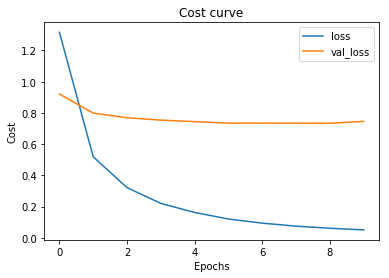

In [35]:
cost_curve(cnn.loss_list, cnn.val_loss_list)

In [0]:
def evalution(y_test, y_pred):
    '''
     分類問題の指標値を出力する関数
 
     Paraeters
     -------------
    y_test : 次の形のndarray, shape (n_samples, )
        正解値
    y_pred : 次の形のndarray, shape (n_samples, )
        予測したラベル
    '''
    #accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy :', accuracy)

    #precision
    precision = precision_score(y_test, y_pred, average='macro')
    print('precision :', precision)

    #recall
    recall = recall_score(y_test, y_pred, average='macro')
    print('recall :', recall)

    #f1
    f1 = f1_score(y_test, y_pred, average='macro')
    print('f1 :', f1)

In [37]:
evalution(y_test, y_pred)

accuracy : 0.775
precision : 0.7866978609625669
recall : 0.7419892813584764
f1 : 0.7451650639494509


時間がかかるため、MNISTのtrain, testデータそれぞれ1/100にして実施。  
lossは下がったが、val_lossは下がらず、過学習傾向があった。  
testデータで精度を確認したが、あまり高いと言えない結果となった。 

## 【問題6】（アドバンス課題）パディングの実装

畳み込み層にパディングを加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。

最も単純なパディングは全て0で埋めるゼロパディングであり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。

フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。

なお、NumPyにはパディングの関数が存在します。

[numpy.pad — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.pad.html)

## 【問題7】（アドバンス課題）ミニバッチへの対応

ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

## 【問題8】（アドバンス課題）任意のストライド数

ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。